## 1. Import Library

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgb
import optuna.integration.lightgbm as op_lgb
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score 
from sklearn.metrics import confusion_matrix

import utils

## 2. Load data

In [3]:
train = pd.read_csv("../data/train.csv")
test = pd.read_csv("../data/test.csv")
genre = pd.read_csv("../data/genre_labels.csv")

In [4]:
train.drop(["index"], axis=1, inplace=True)
train

,genre,popularity,duration_ms,acousticness,positiveness,danceability,loudness,energy,liveness,speechiness,instrumentalness,tempo,region
0,10,11,201094,0.112811,0.157247,0.187841,-1.884852,0.893918,0.363568,0.390108,0.888884,121-152,region_H
1,8,69,308493,0.101333,0.346563,0.554444,-5.546495,0.874409,0.193892,0.161497,0.123910,153-176,region_I
2,3,43,197225,0.496420,0.265391,0.457642,-9.255670,0.439933,0.217146,0.369057,0.166470,64-76,region_E
3,10,45,301092,0.165667,0.245533,0.356578,-5.088788,0.868704,0.377025,0.226677,0.175399,177-192,region_C
4,3,57,277348,0.190720,0.777578,0.830479,-3.933896,0.650149,0.169323,0.222488,0.226030,97-120,unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4041,10,38,246309,0.128795,0.329718,0.575830,-5.252543,0.509531,0.193781,0.187331,0.158197,121-152,region_P
4042,5,23,208734,0.778732,0.228757,0.394283,-14.225700,0.322871,0.253108,0.141218,0.295608,121-152,region_D
4043,10,30,407016,0.402050,0.462374,0.672265,-10.711253,0.646571,0.228189,0.152270,0.163483,97-120,region_E
4044,10,25,204957,0.208096,0.465511,0.523514,-7.855946,0.508910,0.247820,0.202238,0.210184,77-96,region_R


In [5]:
test.drop(["index"], axis=1, inplace=True)
test

,popularity,duration_ms,acousticness,positiveness,danceability,loudness,energy,liveness,speechiness,instrumentalness,tempo,region
0,43,192465,0.559812,0.565035,0.522237,-12.217087,0.620510,0.389727,0.214989,0.161924,77-96,region_I
1,40,226536,0.134002,0.542547,0.493128,-2.612846,0.853089,0.163106,0.184183,0.155460,121-152,unknown
2,58,215385,0.140537,0.643086,0.533189,-3.439684,0.834416,0.429304,0.167352,0.179191,121-152,region_K
3,49,254494,0.266406,0.456733,0.410583,-10.830424,0.534261,0.151830,0.174403,0.186061,77-96,region_D
4,50,230934,0.351907,0.526235,0.645625,-9.099337,0.612474,0.319161,0.157594,0.184142,97-120,region_E
...,...,...,...,...,...,...,...,...,...,...,...,...
4041,34,366668,0.117208,0.316026,0.502289,-2.909329,0.824708,0.320241,0.206592,0.198859,121-152,region_B
4042,53,240081,0.225540,0.391226,0.483655,-5.013634,0.630808,0.163884,0.205218,0.179438,121-152,region_I
4043,48,217839,0.215571,0.828567,0.689747,-8.974036,0.697981,0.318250,0.123748,0.135281,121-152,region_H
4044,45,249612,0.205074,0.730554,0.580581,-1.915320,0.828423,0.360663,0.165837,0.162821,121-152,region_B


In [6]:
genre

,genre,labels
0,country,0
1,electronic,1
2,folk,2
3,hip-hop,3
4,jazz,4
5,latin,5
6,classic,6
7,other-light-music,7
8,pop,8
9,religious,9


## EDA

In [7]:
# genreを削除し、genre_nameを生成
train["genre_name"] = train["genre"].map(dict(zip(genre["labels"], genre["genre"])))
train = train.drop(["genre"], axis=1)

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4046 entries, 0 to 4045
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   popularity        4046 non-null   int64  
 1   duration_ms       4046 non-null   int64  
 2   acousticness      4046 non-null   float64
 3   positiveness      4036 non-null   float64
 4   danceability      4038 non-null   float64
 5   loudness          4046 non-null   float64
 6   energy            4046 non-null   float64
 7   liveness          4043 non-null   float64
 8   speechiness       4038 non-null   float64
 9   instrumentalness  4045 non-null   float64
 10  tempo             4046 non-null   object 
 11  region            4046 non-null   object 
 12  genre_name        4046 non-null   object 
dtypes: float64(8), int64(2), object(3)
memory usage: 411.0+ KB


In [9]:
train.describe()

,popularity,duration_ms,acousticness,positiveness,danceability,loudness,energy,liveness,speechiness,instrumentalness
count,4046.000000,4.046000e+03,4046.000000,4036.000000,4038.000000,4046.000000,4046.000000,4043.000000,4038.000000,4045.000000
mean,41.056105,2.421410e+05,0.346455,0.464100,0.504347,-7.715659,0.603663,0.265986,0.198655,0.214336
std,16.165708,8.520241e+04,0.241004,0.225052,0.158415,4.109640,0.201020,0.155769,0.083557,0.154281
min,0.000000,5.998000e+03,0.000000,0.000000,0.013839,-37.820457,0.003383,0.000000,0.000000,0.000000
25%,31.000000,2.044420e+05,0.149705,0.276384,0.392581,-9.775363,0.462137,0.168527,0.148698,0.143295
50%,42.000000,2.358735e+05,0.250711,0.450211,0.510993,-7.189460,0.634078,0.218486,0.183190,0.171708
75%,52.000000,2.724020e+05,0.523088,0.644786,0.617371,-4.876553,0.768768,0.317773,0.224999,0.205446
max,82.000000,2.135773e+06,1.000000,0.989661,1.000000,0.000000,1.000000,1.000000,0.886806,1.000000


<AxesSubplot:>

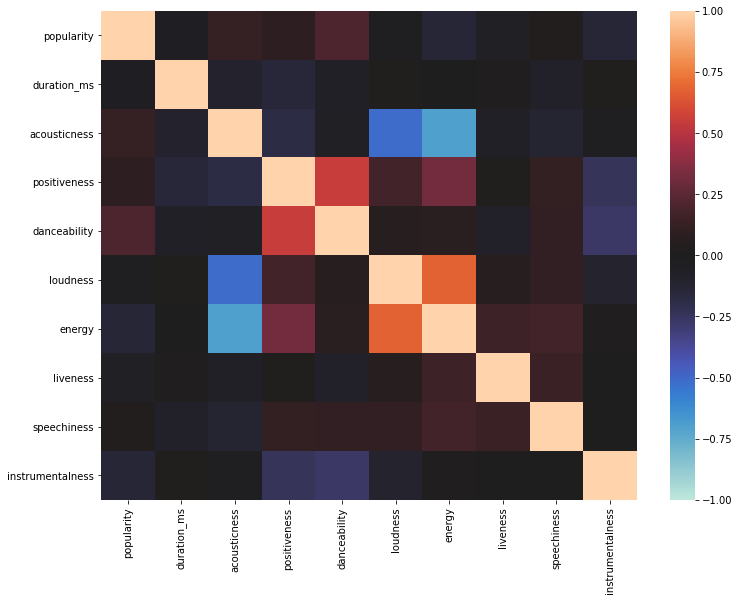

In [10]:
corr = train.corr()
fig, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corr, vmax=1, vmin=-1, center=0)
# sns.clustermap(corr, vmax=1, vmin=-1, center=0)

<AxesSubplot:xlabel='genre_name', ylabel='Count'>

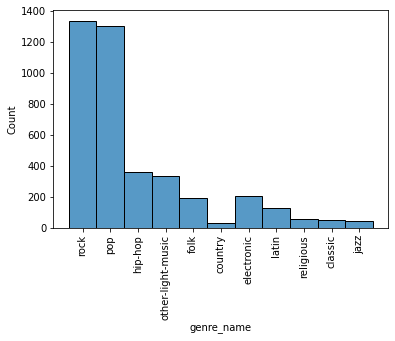

In [11]:
plt.xticks(rotation=90)
sns.histplot(train["genre_name"])

In [15]:
def create_group_histplot(df, group_key, group_value):
    for i, g in df.groupby(group_key)[group_value]:
        fig, ax = plt.subplots()
        plt.title(i)
        plt.xticks(rotation=90)
        sns.histplot(g)

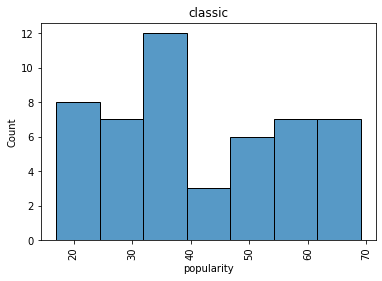

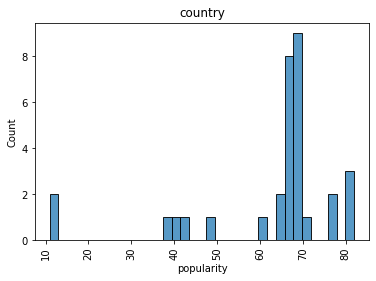

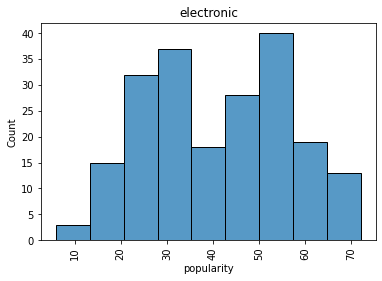

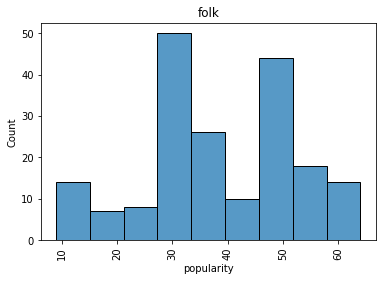

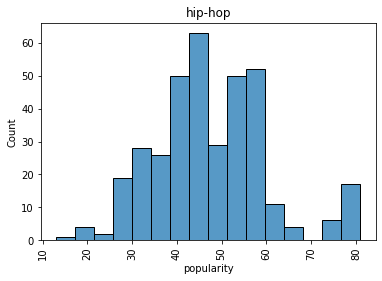

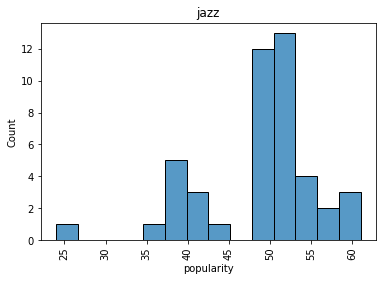

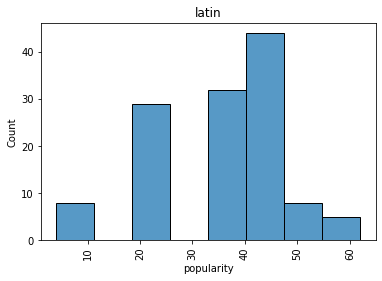

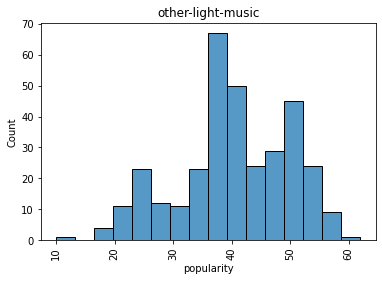

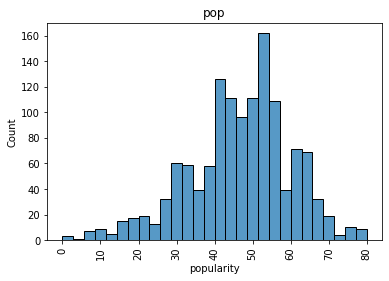

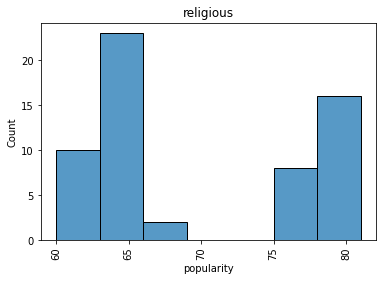

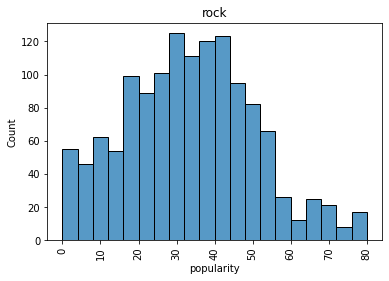

In [16]:
# genreごとのpopularityの分布をプロット
create_group_histplot(train, group_key="genre_name", group_value="popularity")

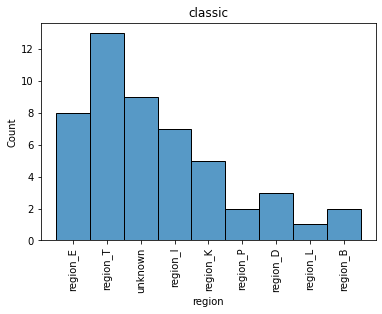

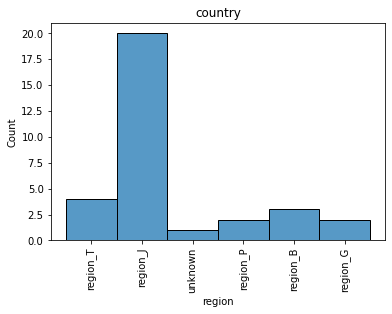

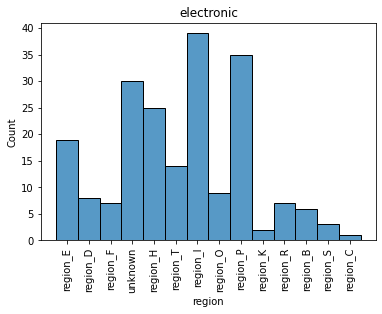

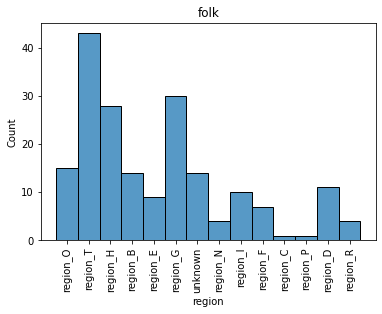

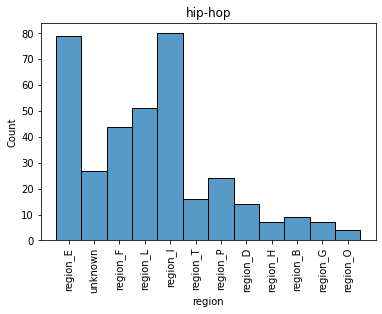

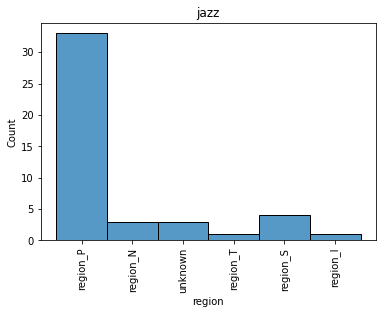

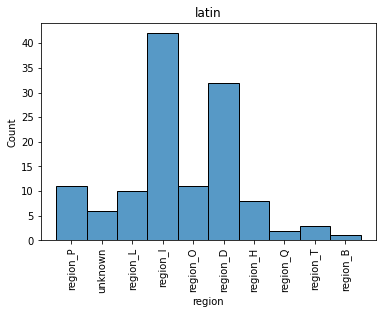

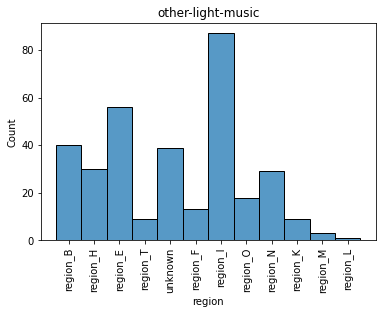

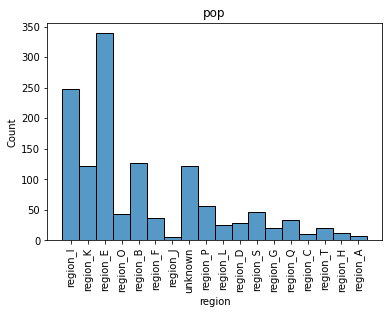

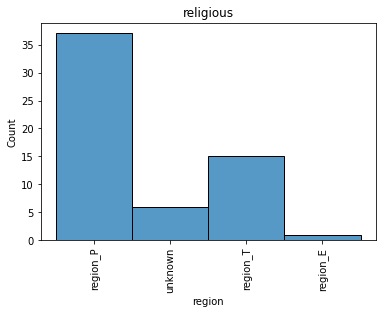

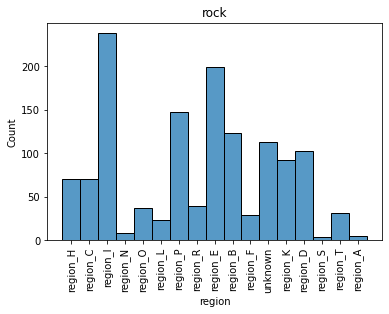

In [17]:
# genreとregionの関係をheatmapでプロット
create_group_histplot(train, group_key="genre_name", group_value="region")

In [22]:
train[["acousticness", "loudness", "energy"]].describe()

,acousticness,loudness,energy
count,4046.000000,4046.000000,4046.000000
mean,0.346455,-7.715659,0.603663
std,0.241004,4.109640,0.201020
min,0.000000,-37.820457,0.003383
25%,0.149705,-9.775363,0.462137
50%,0.250711,-7.189460,0.634078
75%,0.523088,-4.876553,0.768768
max,1.000000,0.000000,1.000000
